# Load data images from disk

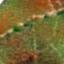

In [1]:
import os
from keras.preprocessing import image

base_dir = '/tf/data'

# Directories for training and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#Directory with training coffee pictures
train_coffee_dir = os.path.join(train_dir, 'coffee')
# Directory with training noncoffee pictures
train_noncoffee_dir = os.path.join(train_dir, 'noncoffee')

#Directory with validation coffee pictures
validation_coffee_dir = os.path.join(validation_dir, 'coffee')
# Directory with validation noncoffee pictures
validation_noncoffee_dir = os.path.join(validation_dir, 'noncoffee')

# Directory with test coffee pictures
test_coffee_dir = os.path.join(test_dir, 'coffee')
# Directory with test noncoffee pictures
test_noncoffee_dir = os.path.join(test_dir, 'noncoffee')


img = image.load_img(os.path.join(train_coffee_dir, 
                os.listdir(train_coffee_dir)[3]))

img.show()    # To show the image

# Instantiating the convnet

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

From the 2nd edition of the book "Deep Learning with Python", chapter 8 - Instrantiating a small convnet for dogs vs. cats classification

# Dataset from directories

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
            train_dir,
            image_size = img.size,
            batch_size = 32)
validation_dataset = image_dataset_from_directory(
            validation_dir,
            image_size = img.size,
            batch_size = 32)
test_dataset = image_dataset_from_directory(
            test_dir,
            image_size = img.size,
            batch_size = 32)

Found 1802 files belonging to 2 classes.
Found 598 files belonging to 2 classes.
Found 476 files belonging to 2 classes.


## Data augmentation layer

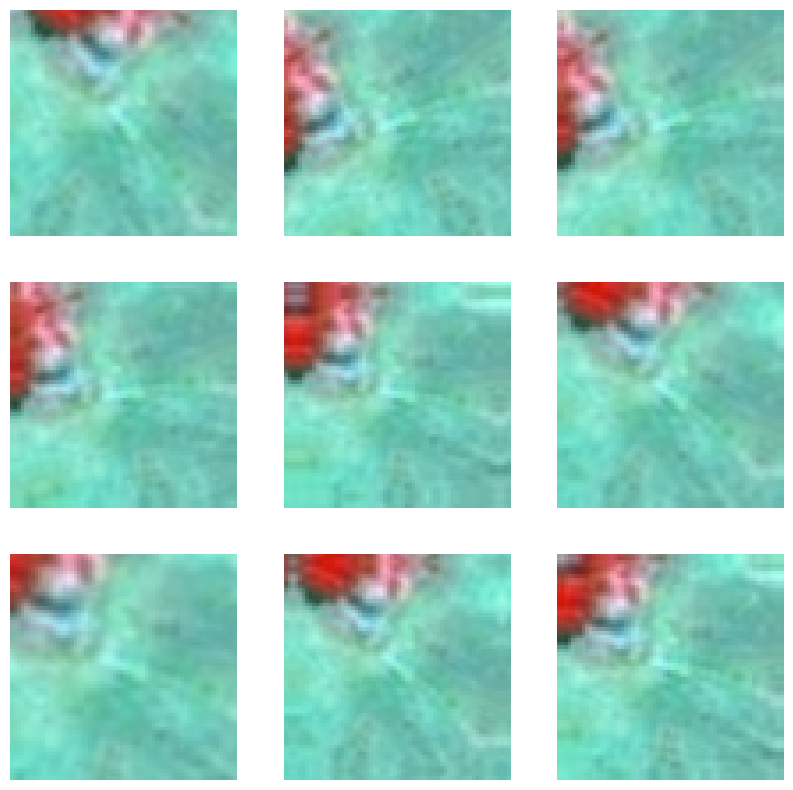

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

# FEATURE EXTRACTION

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img.size[0], img.size[1], 3))

58900480/58889256 [==============================] - 6s 0us/step


Extracting the VGG16 features and corresponding labels

In [6]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [38]:
inputs = keras.Input(shape=(train_features.shape[1], train_features.shape[2], train_features.shape[3]))
# DATA AUGMENTATION
x = data_augmentation(inputs)
x = layers.Flatten()(x)  # Flatten BEFORE passing the features to the Dense layer
x = layers.Dense(int(train_features.shape[3]/2))(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 2, 512)]       0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 524,801
Trainable params: 524,801
Non-trainab

In [40]:
model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

# Training

In [41]:
history = model.fit(
            train_features, train_labels,
            epochs=20,
            validation_data=(val_features, val_labels))

Epoch 1/20
57/57 [==============================] - 1s 5ms/step - loss: 12.4810 - accuracy: 0.7752 - val_loss: 13.1909 - val_accuracy: 0.7074
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 6.2537 - accuracy: 0.8235 - val_loss: 7.3207 - val_accuracy: 0.8144
Epoch 3/20
57/57 [==============================] - 0s 3ms/step - loss: 4.6414 - accuracy: 0.8496 - val_loss: 5.8127 - val_accuracy: 0.8127
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 3.0326 - accuracy: 0.8607 - val_loss: 5.7273 - val_accuracy: 0.8144
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 1.7910 - accuracy: 0.8890 - val_loss: 3.8149 - val_accuracy: 0.8395
Epoch 6/20
57/57 [==============================] - 0s 3ms/step - loss: 1.6291 - accuracy: 0.8912 - val_loss: 6.9157 - val_accuracy: 0.6856
Epoch 7/20
57/57 [==============================] - 0s 3ms/step - loss: 0.9806 - accuracy: 0.8979 - val_loss: 2.8383 - val_accuracy: 0.8244
Epoch 8/20
57/57 [

# Plot

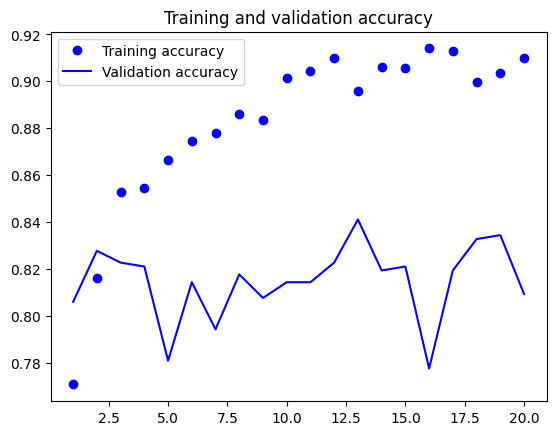

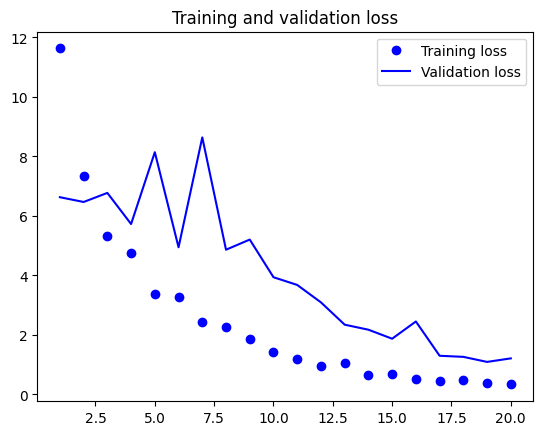

In [33]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Confusion matrix

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

To get the true labels from the validation set:

In [43]:
predicted_batch = model.predict(val_features)
predicted_id = predicted_batch
for i in range(predicted_batch.size):
    predicted_id[i] = 1 if predicted_batch[i] > 0.5 else 0

In [44]:
conf_matrix = confusion_matrix(y_true=val_labels, y_pred=predicted_id)

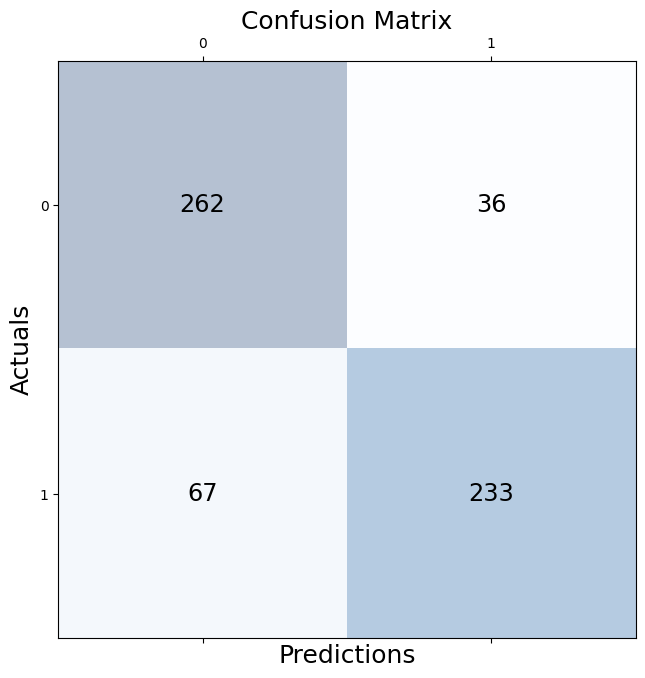

In [45]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()